# Fake News Detection  | Tensorflow | Google Colab

## Big Data
### M2, Statistics & Econometrics, TSE

The goal of this term project is to classify a news as fake news on a Kaggle dataset. This notebook uses deep learning methods to predict the fake news. We construct a deep learning - recurrent neural network using LSTM to predict the same. The latter solves the vanishing gradient problem so that it can capture longer-term dependencies. 
The notebook contains : 
- Text mining : preprocessing 
    - Removing spaces
    - Removing punctuations
    - Removing stop words

- One hot encoding of the tokenized vocabulary
- Padding
- Building the Recurrent Neural Network  with layers : 
    - LSTM
    - Relu 
    - Sigmoid

- Checking for overfitting
- Hyper parameter tuning
    - Learning rate
    - Units of the dense layer

Here again we shall be splitting the training set to obtain a test set to evaluate our predictions given we do not have the final labels for the original test set given by Kaggle.

**Kernel : Python 3**

## I. Loading the prerequisites & data

In [ ]:
pip install -q -U keras-tuner

In [1]:
# Universal
import re
import string
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import math
from collections import Counter
from datetime import datetime
import gc 

# Text mining
import nltk
from nltk import Text
from nltk import tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
# Term Document Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

import kerastuner as kt


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


ModuleNotFoundError: No module named 'kerastuner'

In [2]:
train_df = pd.read_csv("train.csv") 
print(train_df.shape)

(20800, 5)


In [4]:
# Preview the first 5 lines of the train data 
train_df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [5]:
# # Preview the first 5 lines of the test data 
# test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


## II. Some preliminary cleaning !

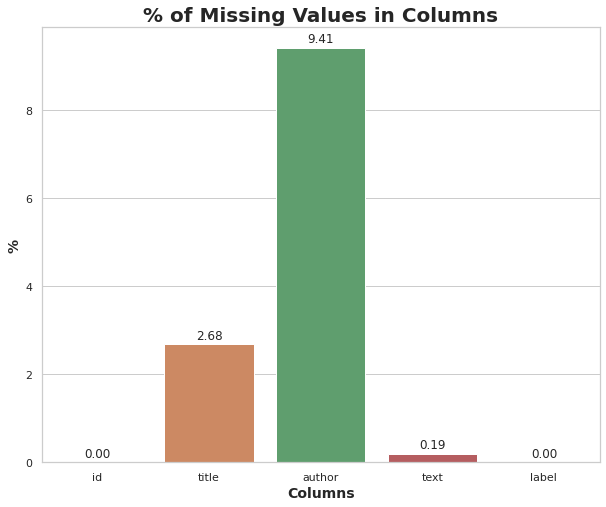

In [6]:
# Inspored by : Twitter Sentiment analysis, Kurtis Pykes. 
# github : https://github.com/kurtispykes/twitter-sentiment-analysis/blob/master/notebook/03_kpy_data_exploration.ipynb


# Visualising the missing values % 
missing_values = dict(zip([col for col in train_df.columns if col != "labels"],
                          [round(100*train_df[col].isnull().sum()/len(train_df), 2) for col in train_df.columns
                           if col != "labels"]))
missing_values_df = pd.DataFrame(missing_values, index=[0])
missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# plotting missing values chart
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("% of Missing Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("%", size=14, weight="bold")
plt.show()

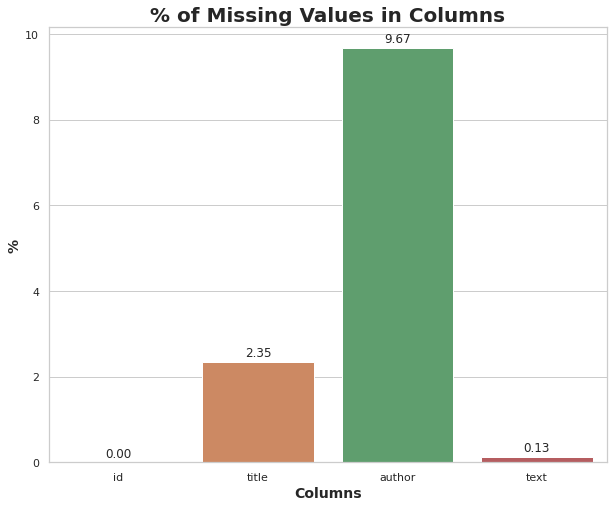

In [7]:
# Commenting this out as it is for the original kaggle test set 
# # Doing the same for the test set
# # Inspired by : Twitter Sentiment analysis, Kurtis Pykes. 
# # github : https://github.com/kurtispykes/twitter-sentiment-analysis/blob/master/notebook/03_kpy_data_exploration.ipynb


# # Visualising the missing values % 
# missing_values = dict(zip([col for col in test_df.columns if col != "labels"],
#                           [round(100*test_df[col].isnull().sum()/len(test_df), 2) for col in test_df.columns
#                            if col != "labels"]))
# missing_values_df = pd.DataFrame(missing_values, index=[0])
# missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# # plotting missing values chart
# plt.figure(figsize=(10, 8))
# sns.set(style="whitegrid", color_codes=True)
# seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
# for p in seaborn_plot.patches:
#     seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
#                    va = 'center', xytext = (0, 9), textcoords = 'offset points')
# plt.title("% of Missing Values in Columns", size=20, weight="bold")
# plt.xlabel("Columns", size=14, weight="bold")
# plt.ylabel("%", size=14, weight="bold")
# plt.show()

### II.A. Dealing with NAs

In [6]:
train_df.fillna("missing", inplace=True)
# test_df.fillna("missing", inplace=True)

## III. Text Mining : Preprocessing 

Our corpus is massive and to reduce the time for pre-processing, we ought to remove punctuations, special characters and single letters. The idea is therefore to pre-process the data which will then be fed to the vectorizer function. 
The pre-processing shall include the following steps 

- Cleaning the text : converting to lower text, removing the punctuations, URLS, special characters etc. 
- Tokenization
- Removing the stop words
- Stemming :The process of extracting the root of the word.

We shall first concatenate the text, title and author columns and tokenize that.

In [7]:
train_df['combined_title_text'] = train_df['title'].map(str) + ' ' + train_df['text'].map(str)
train_df['combined_title_text'] = train_df['combined_title_text'].astype("str")

In [9]:
# Let us first remove the stop words
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Here we define a function to 
- change to lower case
- remove URLs
- remove special characters
- punctuations
- single characters

We then tokenize the corpus. Thereon we stem (taking only the root of the word) the words. Lemmatizing takes a lot more time and there is not a HUGE difference in prediction accuracy (I have tried it myself, using it for other projects) - the time cost outweighs the benefits. 

In [10]:
def preprocess_text(text):
    # Converting to lower case
    text.lower()
    # Remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from text
    text = re.sub(r'\@\w+|\#','', text)
    # Remove punctuations
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text)
    # Remove characters of 3 characters
    text = re.sub(r'\b\w{1,3}\b', '', text)
    # Remove other special chars
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    # Tokenizing the corpus
    text_tokens = word_tokenize(text)
    # Remove stopwords
    filtered_words = [w for w in text_tokens if not w in stop_words]
    # Stemming the corpus
    ps = PorterStemmer()
    #  lemmatizer = WordNetLemmatizer() 
    stemmed_words = [ps.stem(w) for w in filtered_words]
    
    return " ".join(stemmed_words)

### III.A. Obtaining the vocabulary

In [11]:
train_preprocessed =train_df['combined_title_text'].apply(preprocess_text)
# test_preprocessed = test_df['combined_title_text'].apply(preprocess_text)

### III.B. Word Embeddings

The Embedding layer expects the words to be in numeric form. Therefore, we need to convert the sentences in our corpus to numbers. One way to convert text to numbers is by using the one_hot function from the keras.preprocessing.text library. The function takes sentence and the total length of the vocabulary and returns the sentence in numeric form.

In [13]:
# We want the maximum words in our vocabulary to be 1000, or 1000 features at max.
vocab_length = 1000
embedded_sentences_train = [one_hot(sent, vocab_length) for sent in train_preprocessed]
# embedded_sentences_test = [one_hot(sent, vocab_length) for sent in test_preprocessed]
print(embedded_sentences_train[0] )

[230, 848, 896, 260, 887, 928, 657, 907, 671, 599, 850, 827, 127, 4, 569, 247, 263, 544, 657, 907, 680, 346, 684, 990, 196, 848, 61, 724, 626, 121, 697, 505, 377, 104, 458, 818, 708, 387, 318, 480, 720, 550, 528, 631, 969, 16, 745, 300, 279, 724, 794, 87, 579, 848, 238, 924, 176, 762, 52, 112, 856, 497, 279, 724, 813, 627, 907, 667, 488, 848, 57, 349, 881, 393, 786, 95, 798, 404, 993, 431, 951, 71, 192, 50, 961, 964, 892, 720, 671, 599, 711, 500, 798, 300, 34, 974, 848, 947, 469, 974, 515, 14, 611, 477, 34, 696, 974, 682, 465, 964, 521, 24, 280, 127, 242, 263, 877, 223, 264, 657, 907, 112, 685, 871, 254, 687, 104, 635, 153, 65, 701, 656, 284, 374, 234, 807, 725, 263, 260, 361, 10, 896, 917, 800, 877, 982, 787, 932, 584, 192, 24, 724, 832, 355, 498, 512, 635, 735, 869, 500, 735, 185, 584, 995, 223, 964, 616, 892, 848, 842, 412, 865, 766, 842, 656, 657, 907, 178, 666, 874, 144, 61, 582, 656, 17, 423, 104, 219, 354, 892, 643, 277, 94, 255, 500, 834, 210, 685, 584, 787, 819, 398, 693, 884,

### III.C. Padding 
We take the maximum words to keep to be 50. The reason is that I do not want a largely sparse matrix which is inefficient in handling. I had initially taken it to be the largest word count of the sentences in the train set but the model would not work greatly, so after making some trial and errors (20,50, 100 and 1000) I saw that the model performed best for 50. In fact for larger dimensions (100), it would not work well - the accuracy would be quite bad, mainly because of how sparse the matrix would be. 


**Post-padding**
From the tensorflow tutorial : We recommend using "post" padding when working with RNN layers (in order to be able to use the CuDNN implementation of the layers).
Although we will not be seeing the CuDNN implementation, we keep it anyway

In [118]:
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(train_df.combined_title_text, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))
print('the word count of the longest sentence in the train set is : {} '.format(length_long_sentence))

padded_sentences_train = pad_sequences(embedded_sentences_train, 50  , padding='post')
# padded_sentences_test = pad_sequences(embedded_sentences_test,  50 , padding='post')

# print(padded_sentences)

## IV. Creating the RNN model  
We will be using a LSTM model. This has been derived from most of the pre-existing works (the layers that have worked best) on text classification. The idea behind choosing LSTM is that it remembers only the important sequence of words and forgets the insignificant words which don’t add value to the prediction. We have also used a relu activation.  The last layer is a sigmoid as we have a classification problem. 

In [149]:
# The vocab length is 1000 
# The dimension of the input vector is 50 as it is the number to which the sentences are padded

embedding_vector_features=50
model = Sequential()
model.add(Embedding(vocab_length, embedding_vector_features, input_length=50))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))

model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-2),metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 50)            50000     
_________________________________________________________________
dropout_23 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)                6464      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 116,929
Trainable params: 116,929
Non-trainable params: 0
_______________________________________________

In [150]:
# Converting the X and y as array
X_final=np.array(padded_sentences_train)
y_final=train_df.label.values

X_final.dtype
#Check shape of X and y final
X_final.shape,y_final.shape

((20800, 50), (20800,))

### IV.A. Running the Model 

In [151]:
# We split the train set into the training and validation data : because we do not have the true labels for the test set.
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)
# Fitting with 10 epochs and 64 batch size
hist_1 = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
260/260 [==============================] - 4s 9ms/step - loss: 0.5086 - accuracy: 0.7352 - val_loss: 0.4404 - val_accuracy: 0.8262
Epoch 2/10
260/260 [==============================] - 2s 7ms/step - loss: 0.3394 - accuracy: 0.8531 - val_loss: 0.3501 - val_accuracy: 0.8445
Epoch 3/10
260/260 [==============================] - 2s 7ms/step - loss: 0.2962 - accuracy: 0.8703 - val_loss: 0.3446 - val_accuracy: 0.8510
Epoch 4/10
260/260 [==============================] - 2s 7ms/step - loss: 0.2644 - accuracy: 0.8842 - val_loss: 0.3540 - val_accuracy: 0.8471
Epoch 5/10
260/260 [==============================] - 2s 7ms/step - loss: 0.2401 - accuracy: 0.8954 - val_loss: 0.3746 - val_accuracy: 0.8510
Epoch 6/10
260/260 [==============================] - 2s 7ms/step - loss: 0.2285 - accuracy: 0.9019 - val_loss: 0.3768 - val_accuracy: 0.8478
Epoch 7/10
260/260 [==============================] - 2s 7ms/step - loss: 0.2001 - accuracy: 0.9159 - val_loss: 0.3790 - val_accuracy: 0.8510
Epoch 

In [152]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [153]:
confusion_matrix(y_test,y_pred)

array([[1883,  249],
       [ 358, 1670]])

In [154]:
# Not bad ! 
accuracy_score(y_test,y_pred)

0.8540865384615385

## V. Checking for overfitting  !
The loss is very low for the training set but higher on the test set. We see a similar performance for the accuracy

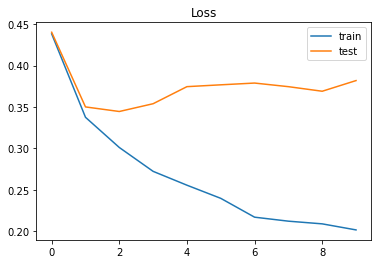

In [155]:
# Overfitting

plt.title('Loss')
plt.plot(hist_1.history['loss'], label='train')
plt.plot(hist_1.history['val_loss'], label='test')
plt.legend()
plt.show();

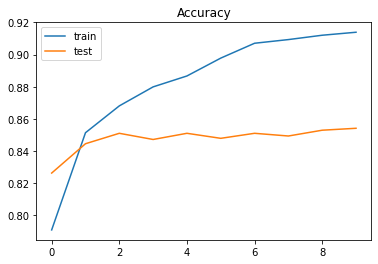

In [156]:
plt.title('Accuracy')
plt.plot(hist_1.history['accuracy'], label='train')
plt.plot(hist_1.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### V.A. Correcting for overfitting 
We increase the dropout rate and add another layer

In [161]:
embedding_vector_features=50
model1=Sequential()
model1.add(Embedding(vocab_length, embedding_vector_features, input_length=50))
model1.add(Dropout(0.5))
model1.add(LSTM(100))
model1.add(Dropout(0.5))
model1.add(Dense(448,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))

model1.add(Dense(1,activation='sigmoid'))

#Compiling the model
model1.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'])
print(model1.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 50, 50)            50000     
_________________________________________________________________
dropout_28 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 448)               45248     
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 449       
Total params: 156,097
Trainable params: 156,097
Non-trainable params: 0
_______________________________________________

In [162]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)
# Fitting with 10 epochs and 64 batch size
hist_2 = model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
260/260 [==============================] - 4s 9ms/step - loss: 0.5122 - accuracy: 0.7523 - val_loss: 0.3632 - val_accuracy: 0.8430
Epoch 2/10
260/260 [==============================] - 2s 7ms/step - loss: 0.3518 - accuracy: 0.8479 - val_loss: 0.3377 - val_accuracy: 0.8478
Epoch 3/10
260/260 [==============================] - 2s 8ms/step - loss: 0.3174 - accuracy: 0.8577 - val_loss: 0.3498 - val_accuracy: 0.8423
Epoch 4/10
260/260 [==============================] - 2s 7ms/step - loss: 0.2898 - accuracy: 0.8706 - val_loss: 0.3433 - val_accuracy: 0.8562
Epoch 5/10
260/260 [==============================] - 2s 7ms/step - loss: 0.2816 - accuracy: 0.8768 - val_loss: 0.3495 - val_accuracy: 0.8589
Epoch 6/10
260/260 [==============================] - 2s 7ms/step - loss: 0.2741 - accuracy: 0.8788 - val_loss: 0.3697 - val_accuracy: 0.8488
Epoch 7/10
260/260 [==============================] - 2s 7ms/step - loss: 0.2538 - accuracy: 0.8894 - val_loss: 0.3664 - val_accuracy: 0.8529
Epoch 

In [159]:
y_pred = (model1.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8512019230769231

##  V.B. Better results ! 
#### Great stuff - earlier the difference in loss was by 0.2 points & now it is less that 0.1 point for the final epoch)
Correcting for overfitting : increase the dropout rate to 0.5 (Dropout technique works by randomly reducing the number of interconnecting neurons within a neural network). We see that the difference in the loss between the train & test has decreased from before. Same for the accuracy.

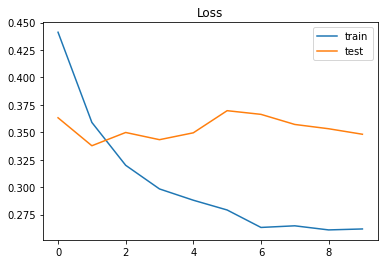

In [163]:
plt.title('Loss')
plt.plot(hist_2.history['loss'], label='train')
plt.plot(hist_2.history['val_loss'], label='test')
plt.legend()
plt.show();

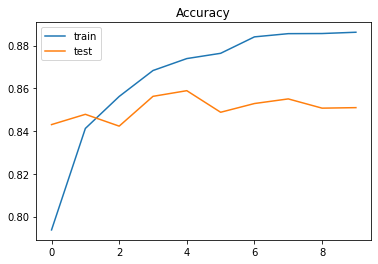

In [165]:
plt.title('Accuracy')
plt.plot(hist_2.history['accuracy'], label='train')
plt.plot(hist_2.history['val_accuracy'], label='test')
plt.legend()
plt.show();

## VI. Hyper-parameter tuning : Using Keras tuner 
- Learning rate
- Number of units 

In [241]:
def model_builder(hp):
  model = keras.Sequential()
  # model.add(Embedding(vocab_length, embedding_vector_features, input_length=100))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(keras.layers.Dense(units=hp_units, activation='relu'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  return model

In [242]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir_1',
                     project_name='intro_to_kt')

INFO:tensorflow:Reloading Oracle from existing project my_dir_1/intro_to_kt/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir_1/intro_to_kt/tuner0.json


In [243]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [244]:
print("You can go for a small coffee break now !") 
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 21 Complete [00h 00m 15s]
val_accuracy: 0.07842548191547394

Best val_accuracy So Far: 0.579026460647583
Total elapsed time: 00h 05m 53s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 192 and the activation is sigmoid & the optimal learning rate for the optimizer
is 0.01.



In [232]:
## This code would ideally help us also to find the best activation function 
# but it does not work.  This is the website to the function below. It is basically
# a function from the keras tuner package that also allows to check for additional
# params but it is not working
# https://keras-team.github.io/keras-tuner/documentation/tuners/#randomsearch-class

# from kerastuner import HyperModel
# class RegressionHyperModel(HyperModel):
#     def __init__(self, input_shape):
#         self.input_shape = input_shape
#     def build(self, hp):
#         model = Sequential()
#         model.add(
#             layers.Dense(
#                 units=hp.Int('units', 8, 64, 4, default=8),
#                 activation=hp.Choice(
#                     'dense_activation',
#                     values=['relu', 'tanh', 'sigmoid'],
#                     default='relu'),
#                 input_shape=input_shape
#             )
#         )
        
#         model.add(
#             layers.Dense(
#                 units=hp.Int('units', 16, 64, 4, default=16),
#                 activation=hp.Choice(
#                     'dense_activation',
#                     values=['relu', 'tanh', 'sigmoid'],
#                     default='relu')
#             )
#         )
        
#         model.add(
#             layers.Dropout(
#                 hp.Float(
#                     'dropout',
#                     min_value=0.0,
#                     max_value=0.1,
#                     default=0.005,
#                     step=0.01)
#             )
#         )
        
        
#         model.compile(
#             optimizer='Adal',loss='mse',metrics=['mse']
#         )
        
#         return model
# input_shape = (X_train.shape[1],)
# hypermodel = RegressionHyperModel(input_shape)
# from kerastuner import HyperModel
# tuner_rs = RandomSearch(
#             hypermodel,
#             objective='mse',
#             seed=42,
#             max_trials=10,
#             executions_per_trial=2)


In [131]:
#Creating the lstm model
embedding_vector_features=50
model2=Sequential()
model2.add(Embedding(vocab_length, embedding_vector_features, input_length=50))
model2.add(Dropout(0.5))
model2.add(LSTM(100))
model2.add(Dropout(0.5))
model2.add(Dense(448,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(448,activation='relu'))

model2.add(Dense(1,activation='sigmoid'))

#Compiling the model
model1.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01),metrics=['accuracy'])
print(model1.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 50)            50000     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 50)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               120800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 448)               90048     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 449       
Total params: 261,297
Trainable params: 261,297
Non-trainable params: 0
________________________________________________

In [132]:
# Train test split of the X and y final
# X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.20, random_state=42)
# Fitting with 10 epochs and 64 batch size
hist_3 = model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
260/260 [==============================] - 6s 16ms/step - loss: 0.4945 - accuracy: 0.7529 - val_loss: 0.3564 - val_accuracy: 0.8387
Epoch 2/10
260/260 [==============================] - 3s 10ms/step - loss: 0.3227 - accuracy: 0.8605 - val_loss: 0.3263 - val_accuracy: 0.8548
Epoch 3/10
260/260 [==============================] - 3s 11ms/step - loss: 0.2652 - accuracy: 0.8842 - val_loss: 0.3394 - val_accuracy: 0.8531
Epoch 4/10
260/260 [==============================] - 3s 11ms/step - loss: 0.2263 - accuracy: 0.9040 - val_loss: 0.3420 - val_accuracy: 0.8502
Epoch 5/10
260/260 [==============================] - 3s 12ms/step - loss: 0.1932 - accuracy: 0.9221 - val_loss: 0.3762 - val_accuracy: 0.8322
Epoch 6/10
260/260 [==============================] - 3s 11ms/step - loss: 0.1785 - accuracy: 0.9255 - val_loss: 0.3963 - val_accuracy: 0.8445
Epoch 7/10
260/260 [==============================] - 3s 11ms/step - loss: 0.1460 - accuracy: 0.9417 - val_loss: 0.4402 - val_accuracy: 0.8459

In [133]:
y_pred = (model1.predict(X_test) > 0.5).astype("int32")
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_pred)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.8411057692307692

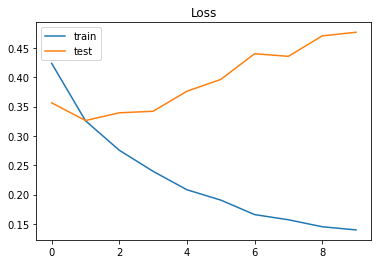

In [134]:
plt.title('Loss')
plt.plot(hist_3.history['loss'], label='train')
plt.plot(hist_3.history['val_loss'], label='test')
plt.legend()
plt.show();

The second model thus gives the best fit. Although the accuracy is more or less the same across the models (it also depends on the train-test split) we prefer a model that does not underfit as much. As I ran a gridsearch for the best params, we overfit **A LOT** again as we see the loss curves are literally diverging.
Limits : 
- I could have tried to correct further why after the gridsearch we see so much overfitting but did not have time
- Check for other word embedding mechanisms - Word2Vec or even other pretrained embeddings, but was short on time.

# You have reached the end of this notebook !